In [1]:
%matplotlib inline
# %matplotlib widget
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

import ipywidgets as wdg  # Using the ipython notebook widgets

In [2]:
import sys
import numpy as np
import os
import cv2

In [3]:
heatmap_name = '/home/code-base/user_space/ai-badminton/notebooks/data/anthony-ginting-beat-kento-momota-anthony-ginting-vs-kento-momota-fo-2019-hlzrivktbyo_heatmap.npz'
video_name = '/home/code-base/user_space/ai-badminton/notebooks/data/anthony-ginting-beat-kento-momota-anthony-ginting-vs-kento-momota-fo-2019-hlzrivktbyo.mp4'

In [4]:
heatmaps = np.load(heatmap_name)
heatmaps = heatmaps['arr_0']

In [5]:
HEIGHT=288
WIDTH=512

cap = cv2.VideoCapture(video_name)
fps = 25

success, image = cap.read()

ratioY = image.shape[0] / HEIGHT
ratioX = image.shape[1] / WIDTH

In [93]:
predictions = []
flows = []
prev = None

from tqdm.notebook import tqdm
for heatmap in tqdm(heatmaps[:2000]):
    rounded_pred = (heatmap > 0.1 * 255) * 255
    rounded_pred = rounded_pred.astype('uint8')

    (cnts, _) = cv2.findContours(rounded_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in cnts]
    get_area = lambda rect: np.sum(heatmap[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]])

    if len(rects) == 0:
        predictions.append([])
        flows.append([])
    else:
        prediction = []
        flow = []
        
        flow_field = None
        if prev is not None:
            flow_field = cv2.calcOpticalFlowFarneback(prev, heatmap, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            
        for j in range(len(rects)):
            target = rects[j]
            avg_wt = get_area(target) / (target[2] * target[3])
            x_out, y_out = (target[0] + target[2] / 2), (target[1] + target[3] / 2)
            (cx_pred, cy_pred) = (ratioX*x_out, ratioY*y_out)
            prediction.append((avg_wt, cx_pred, cy_pred))
            
            if flow_field is not None:
                v_out = flow_field[int(y_out), int(x_out)]
            else:
                v_out = [0, 0]
            flow.append(v_out)
        predictions.append(prediction)
        flows.append(flow)
    
    prev = heatmap

  0%|          | 0/2000 [00:00<?, ?it/s]

In [94]:
# """
# Do a DP with the following state:
#     - Indices of the last 3 points on the current trajectory
    
# f(n, p1, p2, p3) where if a pi == -1, then it was not detected

# if choose to continue the same rally:
#     if p1, p2, p3:
#         - do quadratic interpolation and use this to minimize the distance to
#           the next point
#     if p1, p2:
#         - do linear interpolation
#     if p1:
#         - just compare distance
# if choose to switch directions:
#     - p2 = p2 = -1
#     - p1 = current point
#     - pay beta
# if choose to stop rally:
#     - pay alpha to pause detection
#     - set all 3 to -1
# if choose to start rally:
#     - pay beta
# """

# memo_cost = {}
# memo_choice = {}
# def next_p(p):
#     if p[1] >= len(predictions[p[0]]) - 1:
#         return (p[0] + 1, 0)
#     else:
#         return (p[0], p[1] + 1)

# def get_p(p):
#     return predictions[p[0]][p[1]][1:]

# CHANGE_COST = 10
# NEW_RALLY_COST = 100000
# SKIP_COST = 1000
# def f(pc, p1, p2, p3):
#     if pc[0] == len(predictions):
#         return 0
#     if pc[1] == len(predictions[pc[0]]):
#         return f(next_p(pc), p1, p2, p3)
#     if (pc, p1, p2, p3) in memo_cost:
#         return memo_cost[pc, p1, p2, p3]
    
#     # Predict next point if we have part of the rally already
#     costs = []
#     choices = []
#     choice_desc = []
#     if p1 or p2 or p3:
#         x, y = [], []
#         if p1 and p2 and p3:
#             x = [p1[0], p2[0], p3[0]]
#             y = [get_p(p1), get_p(p2), get_p(p3)]
#         elif p1 and p2:
#             x = [p1[0], p2[0]]
#             y = [get_p(p1), get_p(p2)]
#         elif p1:
#             x = [p1[0]]
#             y = [get_p(p1)]
            
#         deg = len(x) - 1
#         coef = np.polyfit(x, y, len(x)-1)
        
#         Pn = sum(coef[i] * pc[0]**(deg - i) for i in range(deg+1))
#         Pc = np.array(get_p(pc))
        
#         # Try to continue heading in the same direction
#         pcn = next_p(pc)
#         while pcn[0] == pc[0]:
#             pcn = next_p(pcn)
            
#         choices.append((pcn, pc, p1, p2))
#         costs.append(np.linalg.norm(Pn-Pc))
#         choice_desc.append('stay-same')
        
#         # Try to turn around
#         choices.append((pcn, pc, None, None))
#         costs.append(np.linalg.norm(Pn-Pc) + CHANGE_COST)
#         choice_desc.append('change-dir')
        
#     # Try to skip the current point
#     if not p1 and not p2 and not p3:
#         # Continue skipping points
#         choices.append((next_p(pc), None, None, None))
#         costs.append(SKIP_COST)
#         choice_desc.append('skip-point')
        
#         choices.append((next_p(pc), pc, None, None))
#         costs.append(0)
#         choice_desc.append('new-rally-start')
        
#     # Start a new rally from scratch or completely end a rally
#     choices.append((next_p(pc), pc, None, None))
#     costs.append(NEW_RALLY_COST)
#     choice_desc.append('new-rally-start')
    
#     choices.append((next_p(pc), None, None, None))
#     costs.append(NEW_RALLY_COST)
#     choice_desc.append('new-rally-end')
        
#     # Also add a 0 cost option for choosing another point in the current list
#     if next_p(pc)[0] == pc[0]:
#         choices.append((next_p(pc), p1, p2, p3))
#         costs.append(0)
#         choice_desc.append('skip-within')
        
#     for i in range(len(costs)):
#         costs[i] += f(*choices[i])
        
# #     print((pc, p1, p2, p3), '\n', costs, '\n', choices, '\n', choice_desc)
#     best_cost = 1e99
#     best_choice = None
#     best_desc = None
#     for (cost, choice, desc) in zip(costs, choices, choice_desc):
#         if cost < best_cost:
#             best_cost = cost
#             best_choice = choice
#             best_desc = desc
    
#     memo_cost[pc, p1, p2, p3] = best_cost
#     memo_choice[pc, p1, p2, p3] = (best_desc, best_choice)
#     return best_cost

# def get_solution(pc, p1, p2, p3):
#     total_cost = f(pc, p1, p2, p3)
#     soln = []
#     curr = (pc, p1, p2, p3)
#     while curr[0][0] != len(predictions):
#         pc = curr[0]
#         if pc[1] == len(predictions[pc[0]]):
#             curr = (next_p(pc), curr[1], curr[2], curr[3])
#             soln[-1].append(None)
#             continue
    
#         desc = memo_choice[curr][0]
#         if desc == 'stay-same':
#             soln[-1].append(predictions[pc[0]][pc[1]][1:])
#         elif desc == 'change-dir' or desc == 'new-rally-start':
#             soln.append([predictions[pc[0]][pc[1]][1:]])
#         elif desc == 'skip-point':
#             soln[-1].append(None)
#         elif desc == 'skip-within':
#             pass
            
#         curr = memo_choice[curr][1]
#     return total_cost, soln

In [95]:
# cost, rallies = get_solution((0,0), None, None, None)
# print(cost)
# print(len(rallies))
# print(sum(len(x) for x in rallies))
# rallies

# Setup

In [96]:
L = 1000
points = predictions[L:2*L]
velocity = flows[L:2*L]

# Greedy solution

In [97]:
positions = []
for i in range(len(points)):
    best_weight = 0
    best_pos = None
    for pos in points[i]:
        if pos[0] > best_weight:
            best_weight = pos[0]
            best_pos = pos[1:]
    
    positions.append(best_pos)

# (Almost) topological data analysis

In [286]:
# Create a graph for each observation
from collections import defaultdict

graph = defaultdict(list)
weight = defaultdict(float)
Lt = 2
Leps = 8
for i in range(len(points)):
    for j in range(len(points[i])):
        weight[i, j] = points[i][j][0]
        # Search back and forth Lt steps and find points within eps
        for k in range(max(0, i-Lt), min(len(points), i+Lt+1)):
            if k == i:
                continue
            # Pick the best out all possible prev
            for l in range(len(points[k])):
                diff = np.array(points[i][j][1:]) - np.array(points[k][l][1:])
                if np.all(np.abs(diff) < Leps * np.abs(velocity[i][j])):
                    graph[i, j].append((k, l))
                    graph[k, l].append((i, j))

In [287]:
# Now find the components of the graph
seen = {}
def dfs(v, num):
    stack = [v]
    seen[v] = num
    comp = [v]
    while len(stack):
        v = stack.pop()
        if v not in graph:
            continue
        for w in graph[v]:
            if w not in seen:
                seen[w] = num
                stack.append(w)
                comp.append(w)
                
    return comp

compweight = defaultdict(float)
compsize = defaultdict(int)
compid = 0
for v in graph:
    if v not in seen:
        comp = dfs(v, compid)
        compw = sum(weight[v] for v in comp)
        for w in comp:
            compweight[w] = compw
            compsize[w] = len(comp)
        compid += 1

components = defaultdict(list)
for v in graph:
    components[seen[v]].append(v)
    
X = components.values()

In [288]:
Lcomp = 10
sorted_comps = []
for compv in components.values():
    if len(compv) > Lcomp:
        sorted_comps.append((-compweight[compv[0]], compv))
sorted_comps.sort()

In [289]:
# Iterate through components in decreasing weight, doing linear interpolation / collision checking with other comps
done = np.array([0] * L)
filtered = []
for score, comp in sorted_comps:
    m, M = min(x[0] for x in comp), max(x[0] for x in comp)
    if any(done[m:M+1]):
        continue
    done[m:M] = 1
    split_by_id = defaultdict(list)
    for i, j in comp:
        split_by_id[i].append((points[i][j], velocity[i][j]))
    for i in range(m, M+1):
        if i in split_by_id:
            split_by_id[i] = sorted(split_by_id[i], reverse=True)
            filtered.append((i, split_by_id[i][0]))

positions = []
velocities = []
weights = []
cnt = 0
for i, p in sorted(filtered):
    while cnt < i:
        positions.append(None)
        velocities.append(None)
        weights.append(None)
        cnt += 1
    positions.append(p[0][1:])
    velocities.append(p[1])
    weights.append(p[0][0])
    cnt += 1

In [290]:
# Lcomp = 10
# filtered_preds = []
# for i in range(L):
#     filtered_preds.append([])
#     for j in range(len(points[i])):
#         if compsize[(i, j)] > Lcomp:
#             filtered_preds[-1].append((compweight[i,j], points[i][j]))

# positions = []
# for i in range(L):
#     best_score = 0
#     best_pt = None
#     for j in range(len(filtered_preds[i])):
#         score = filtered_preds[i][j][0] + filtered_preds[i][j][1][0]
#         if score > best_score:
#             best_score = score
#             best_pt = filtered_preds[i][j][1][1:]
#     positions.append(best_pt)

In [291]:
import math
import pandas as pd

pos_array = [pos if pos is not None else (math.nan, math.nan) for pos in positions]
pos_array = np.array(pos_array)
vel_array = [vel if vel is not None else (math.nan, math.nan) for vel in velocities]
vel_array = np.array(vel_array)
w_array = [w if w is not None else 0 for w in weights]
w_array = np.array(w_array).reshape((len(w_array), 1))

for i in range(1, w_array.shape[0]-1):
    if w_array[i-1] and w_array[i]:
        w_array[i] += -np.linalg.norm(pos_array[i-1] - pos_array[i])
    if w_array[i+1] and w_array[i]:
        w_array[i] += -np.linalg.norm(pos_array[i+1] - pos_array[i])
    w_array[i] = max(w_array[i], 0)
    
df = pd.DataFrame(
    data=np.hstack([pos_array, vel_array, w_array]), 
    columns=["x", "y", "vx", "vy", "w"]
)

In [292]:
positions = df.values[:, :2]
velocities = df.values[:, 2:4]

p = 1
weights = df.values[:, 4]**p / sum(df.values[:, 4]**p) * sum(df.values[:, 4])
times = np.array(range(len(weights))) * 1. / fps

from statsmodels.nonparametric.smoothers_lowess import lowess
filtered = lowess(weights, times, is_sorted=True, frac=0.1 * fps / len(weights), it=10)
filtered = filtered[:, 1]
# A = np.average(filtered)
# filtered[filtered < A] = 0
weights = filtered

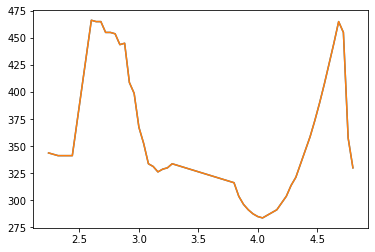

In [293]:
xo = positions[:, 0]
t = times[xo == xo]
x = xo[xo == xo]
filtered = lowess(x, t, is_sorted=True, frac=0.1 * fps / len(weights), it=5)
positions[xo == xo, 0] = filtered[:, 1]

xo = positions[:, 1]
t = times[xo == xo]
x = xo[xo == xo]
filtered = lowess(x, t, is_sorted=True, frac=0.1 * fps / len(weights), it=5)
positions[xo == xo, 1] = filtered[:, 1]

plt.plot(t[50:100], x[50:100])
plt.plot(t[50:100], filtered[50:100, 1])

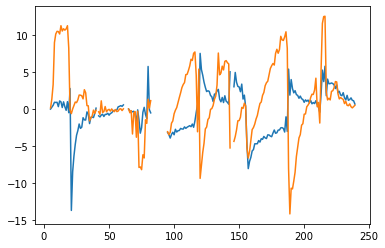

In [294]:
from matplotlib import pyplot as plt

plt.plot(velocities[:240,0])
plt.plot(velocities[:240,1])

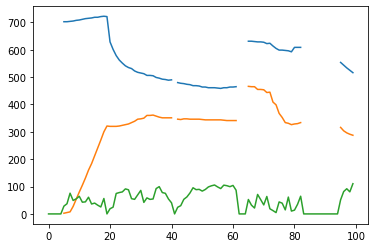

In [295]:
plt.plot(positions[:100, 0])
plt.plot(positions[:100, 1])
plt.plot(weights[:100])

In [296]:
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline

Xb = positions[:, 0]
Yb = positions[:, 1]
i = 0
while i < len(Xb):
    cnt, j = 0, i
    while j < len(Xb) and j - i < 25:
        cnt += Xb[j] == Xb[j]
        j += 1
    coords = [(k, weights[i+k], pos) for k, pos in enumerate(positions[i:j, :2]) if pos[0] == pos[0]]
    
    print(cnt)
    if cnt < 5:
        i = j
        continue
        
    t = np.array([c[0] for c in coords])
    x = np.array([c[2][0] for c in coords])
    y = np.array([c[2][1] for c in coords])
    w = np.array([c[1] for c in coords])
#     w = w / np.sum(w)

    best_score = 1e99
    best_splines = None
#     spline_x = UnivariateSpline(t, x, w, s=5, k=1)
#     spline_y = UnivariateSpline(t, y, w, s=5, k=1)
#     best_splines = [spline_x, spline_y]
#     if j - i > 30:
#     for k0 in range(1, len(t)):
#         for k1 in range(k0+1, len(t)-1):
#             spline_x = LSQUnivariateSpline(t, x, np.array([t[k0], t[k1]]), w=w, k=2)
#             spline_y = LSQUnivariateSpline(t, y, np.array([t[k0], t[k1]]), w=w, k=2)
#             score = spline_x.get_residual() + spline_y.get_residual()
#             if score < best_score:
#                 best_score = score
#                 best_splines = [spline_x, spline_y]
#     else:
    for k0 in range(1, len(t)-1):
        spline_x = LSQUnivariateSpline(t, x, np.array([t[k0]]), w=w, k=2)
        spline_y = LSQUnivariateSpline(t, y, np.array([t[k0]]), w=w, k=2)
        score = spline_x.get_residual() + spline_y.get_residual()
        if score < best_score:
            best_score = score
            best_splines = [spline_x, spline_y]
    
    # Remove broad trends
    sx, sy = best_splines[0](t), best_splines[1](t)
    dx = x - sx
    dy = y - sy
    mx, my = np.average(dx), np.average(dx)
    vx, vy = np.average((dx - mx)**2), np.average((dy - my)**2)
    
#     replaced = False
#     for idx in range(len(t)):
#         if abs(dx[idx]-mx) > vx**0.5+5 or abs(dy[idx]-my) > vy**0.5+5:
#             Xb[i + t[idx]] = sx[idx]
#             Yb[i + t[idx]] = sy[idx]
#             replaced = True
#             print('replaced', i + t[idx])
    
    t = np.array(range(j - i))
    sx, sy = best_splines[0](t), best_splines[1](t)
    for idx in range(len(t)):
        x, y = Xb[i + t[idx]], Yb[i + t[idx]]
        if x != x or abs(x-sx[idx]-mx) > 2 * vx**0.5+5 or abs(y-sy[idx]-my) > 2 * vy**0.5+5:
            Xb[i + t[idx]] = sx[idx]
            Yb[i + t[idx]] = sy[idx]
        
#     if replaced:
#         print(i, j)
#         t_knots = spline_x.get_knots()
#         plt.plot(t, sx)
#         plt.plot(t, sy)
#         plt.plot(t, x)
#         plt.plot(t, y)
#         plt.plot(t_knots, best_splines[0](t_knots), 'o', color='red', label='knots')
#         plt.plot(t_knots, best_splines[1](t_knots), 'o', color='green', label='knots')
#         plt.figure()
    
    i = j
#     i += 10

positions[:, 0] = Xb
positions[:, 1] = Yb

20
24
22
13
25
23
25
25
25
17
16
25
25
24
24
24
25
24
0
0
19
25
16
13
19
25
24
0
0
19
25
16
25
25
25
22
13
25
25
23


In [297]:
# from scipy.signal import butter, filtfilt

# def butter_lowpass_filter(data, cutoff, fs, order):
#     nyq = 0.5 * fs
#     normal_cutoff = cutoff / nyq
#     # Get the filter coefficients 
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     y = filtfilt(b, a, data)
#     return y
    
# positions[:, 0] = butter_lowpass_filter(positions[:, 0], 4, fps, 3)
# positions[:, 1] = butter_lowpass_filter(positions[:, 1], 4, fps, 3)

In [298]:
# positions = df.values
# s_old = 1e99
# while True:
#     Xb = positions[:, 0]
#     Yb = positions[:, 1]

#     def diff(X):
#         Z = []
#         for i in range(X.shape[0]-1):
#             if X[i] != X[i] or X[i+1] != X[i+1]:
#                 continue
#             Z.append(abs(X[i+1] - X[i]))
#         return np.array(Z)

#     xa, ya = np.average(diff(Xb)), np.average(diff(Yb))
#     vx, vy = np.average((diff(Xb) - xa)**2), np.average((diff(Yb) - ya)**2)

#     for i in range(len(Xb)-1):
#         if Xb[i] != Xb[i]:
#             continue
#         if i > 1 and Xb[i-1] != Xb[i-1] and Xb[i+1] != Xb[i+1]:
#             Xb[i] = Yb[i] = math.nan
#             continue
            
#         d0 = abs(Xb[i+1] - Xb[i])
#         d1 = abs(Yb[i+1] - Yb[i])

#         if d0 > xa + 3 * vx**0.5 or d1 > ya + 3 * vy**0.5:
#             Xb[i] = math.nan
#             Yb[i] = math.nan
    
#     if vx + vy < sold:
#         s_old = vx + vy
#     else:
#         break

# # df.interpolate(method='slinear', inplace=True)
# # df.fillna(method='bfill', inplace=True)
# # df.fillna(method='ffill', inplace=True)
# positions[:, 0] = Xb
# positions[:, 1] = Yb

In [299]:
len(positions)

998

In [300]:
cap = cv2.VideoCapture(video_name)
count = 0

cap.set(cv2.CAP_PROP_POS_FRAMES, L-1)

size = (image.shape[1], image.shape[0])
fps = 25
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output/test.mp4', fourcc, fps, size)

for pos in tqdm(positions):
    _, frame = cap.read()
    if pos is not None and pos[0] == pos[0]:
        cv2.circle(frame, (int(pos[0]), int(pos[1])), 10, (0, 0, 255), -1)
    out.write(frame)
out.release()

  0%|          | 0/998 [00:00<?, ?it/s]

In [608]:
# cap = cv2.VideoCapture(video_name)
# count = 0

# size = (image.shape[1], image.shape[0])
# fps = 25
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter('output/control.mp4', fourcc, fps, size)

# for poslist in points:
#     bestScore = 0
#     pos = None
#     for cpos in poslist:
#         if cpos[0] > bestScore:
#             bestScore = cpos[0]
#             pos = cpos[1:]
            
#     _, frame = cap.read()
#     if pos is not None:
#         cv2.circle(frame, (int(pos[0]), int(pos[1])), 10, (0, 0, 255), -1)
#     out.write(frame)
# out.release()

KeyboardInterrupt: 

In [ ]:
# cap = cv2.VideoCapture(video_name)
# count = 0

# size = (image.shape[1], image.shape[0])
# fps = 25
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter('output/test.mp4', fourcc, fps, size)

# for rid, rally in enumerate(rallies):
#     for pos in rally:
#         _, frame = cap.read()
#         count += 1
#         if pos is not None:
#             cv2.circle(frame, (int(pos[0]), int(pos[1])), 10, (0,0,255) if rid % 2 else (255,0,0), -1)
#         out.write(frame)
# out.release()

In [312]:
cap = cv2.VideoCapture(video_name)
count = 0

size = (image.shape[1], image.shape[0])
fps = 25
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output/heatmap.mp4', fourcc, fps, size)

cap = cv2.VideoCapture(video_name)
count = 0

cap.set(cv2.CAP_PROP_POS_FRAMES, L-1)
for heatmap in tqdm(heatmaps[L:2*L]):
    heatmap = cv2.resize(heatmap, size)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_GRAY2RGB)
    _, frame = cap.read()
    X = 0.7 * heatmap + 0.3 * frame
    X = X.astype('uint8')
    out.write(X)
out.release()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [307]:
np.max(heatmaps[L:2*L][0])

14